# 15.2b: Evaporation vs Coalescence

**Distinguish between two mechanisms for black hole count decline**

## Two Hypotheses

### Hypothesis 1: Evaporation
- Tokens **escape** from black holes via gradients
- Black holes shrink as population decreases
- **Prediction:** Total population in black holes decreases along with black hole count

### Hypothesis 2: Coalescence
- Tokens **merge** from smaller black holes into larger ones
- Black holes consolidate but don't lose tokens
- **Prediction:** Total population in black holes stays constant (or increases) while count decreases

## Diagnostic

Plot both:
1. **Number of black holes** (count of vectors with pop ≥ 2)
2. **Total black hole population** (sum of all tokens in black holes)

**If evaporation:** Both curves drop together (parallel decline)

**If coalescence:** Count drops, population flat or rising (diverging curves)

## Parameters

In [1]:
# Data paths
F32_BF16_PATH = "../data/comprehensive_run/comprehensive_training_data.safetensors"
PURE_BF16_PATH = "../data/control_run_bf16/control_training_data_bf16.safetensors"

# Plot settings
DPI = 100

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading f32→bf16 run (15.1a)...")
data_f32 = load_file(F32_BF16_PATH)

print("Loading pure bf16 run (15.1b)...")
data_bf16 = load_file(PURE_BF16_PATH)

dead_token_ids = data_f32['dead_token_ids']
n_dead = len(dead_token_ids)

print(f"\n✓ Data loaded")
print(f"  Dead tokens: {n_dead}")
print(f"  f32→bf16 steps: {len(data_f32['recorded_steps'])}")
print(f"  pure bf16 steps: {len(data_bf16['recorded_steps'])}")

Loading f32→bf16 run (15.1a)...
Loading pure bf16 run (15.1b)...

✓ Data loaded
  Dead tokens: 51
  f32→bf16 steps: 10001
  pure bf16 steps: 10001


## Compute Black Hole Statistics

For each step, compute:
1. Number of black holes (vectors with pop ≥ 2)
2. Total population in black holes (sum of all tokens in those vectors)

In [4]:
def compute_black_hole_stats(embeddings, dead_ids):
    """
    Compute black hole statistics at each step.
    
    Returns:
        black_hole_counts: [n_steps] number of black holes (pop ≥ 2)
        black_hole_population: [n_steps] total tokens in black holes
    """
    n_steps = embeddings.shape[0]
    black_hole_counts = []
    black_hole_population = []
    
    for step in tqdm(range(n_steps), desc="Computing statistics"):
        dead_embeddings = embeddings[step, dead_ids, :]
        
        # Get unique vectors and their populations
        unique_vecs, inverse_indices = torch.unique(dead_embeddings, dim=0, return_inverse=True)
        populations = torch.bincount(inverse_indices)
        
        # Count black holes (pop ≥ 2)
        black_hole_mask = populations >= 2
        num_black_holes = black_hole_mask.sum().item()
        black_hole_counts.append(num_black_holes)
        
        # Total population in black holes
        total_pop = populations[black_hole_mask].sum().item()
        black_hole_population.append(total_pop)
    
    return np.array(black_hole_counts), np.array(black_hole_population)

print("Processing f32→bf16 run...")
bh_count_f32, bh_pop_f32 = compute_black_hole_stats(
    data_f32['embeddings'], 
    dead_token_ids
)

print("\nProcessing pure bf16 run...")
bh_count_bf16, bh_pop_bf16 = compute_black_hole_stats(
    data_bf16['embeddings'], 
    dead_token_ids
)

print("\n✓ Statistics computed")

Processing f32→bf16 run...


Computing statistics: 100%|██████████| 10001/10001 [00:01<00:00, 9024.43it/s]



Processing pure bf16 run...


Computing statistics: 100%|██████████| 10001/10001 [00:01<00:00, 8976.69it/s]


✓ Statistics computed


## Summary Statistics

In [5]:
steps = data_f32['recorded_steps'].numpy()

print(f"{'='*80}")
print(f"SUMMARY STATISTICS")
print(f"{'='*80}\n")

print(f"f32→bf16 (15.1a):")
print(f"  t=0:    {bh_count_f32[0]} black holes, {bh_pop_f32[0]} tokens")
print(f"  t=final: {bh_count_f32[-1]} black holes, {bh_pop_f32[-1]} tokens")
print(f"  Change: {bh_count_f32[-1] - bh_count_f32[0]:+d} black holes, {bh_pop_f32[-1] - bh_pop_f32[0]:+d} tokens")

print(f"\npure bf16 (15.1b):")
print(f"  t=0:    {bh_count_bf16[0]} black holes, {bh_pop_bf16[0]} tokens")
print(f"  t=final: {bh_count_bf16[-1]} black holes, {bh_pop_bf16[-1]} tokens")
print(f"  Change: {bh_count_bf16[-1] - bh_count_bf16[0]:+d} black holes, {bh_pop_bf16[-1] - bh_pop_bf16[0]:+d} tokens")

# Compute correlation between count and population changes
# If evaporation: high correlation (both drop together)
# If coalescence: low/negative correlation (count drops, pop stable/rises)
from scipy.stats import pearsonr

corr_f32, pval_f32 = pearsonr(bh_count_f32, bh_pop_f32)
corr_bf16, pval_bf16 = pearsonr(bh_count_bf16, bh_pop_bf16)

print(f"\nCorrelation (count vs population):")
print(f"  f32→bf16: r = {corr_f32:.3f} (p = {pval_f32:.2e})")
print(f"  pure bf16: r = {corr_bf16:.3f} (p = {pval_bf16:.2e})")

print(f"\n{'='*80}")

SUMMARY STATISTICS

f32→bf16 (15.1a):
  t=0:    3 black holes, 6 tokens
  t=final: 9 black holes, 43 tokens
  Change: +6 black holes, +37 tokens

pure bf16 (15.1b):
  t=0:    10 black holes, 34 tokens
  t=final: 1 black holes, 51 tokens
  Change: -9 black holes, +17 tokens

Correlation (count vs population):
  f32→bf16: r = 0.873 (p = 0.00e+00)
  pure bf16: r = -0.769 (p = 0.00e+00)



## Plot: Evaporation vs Coalescence

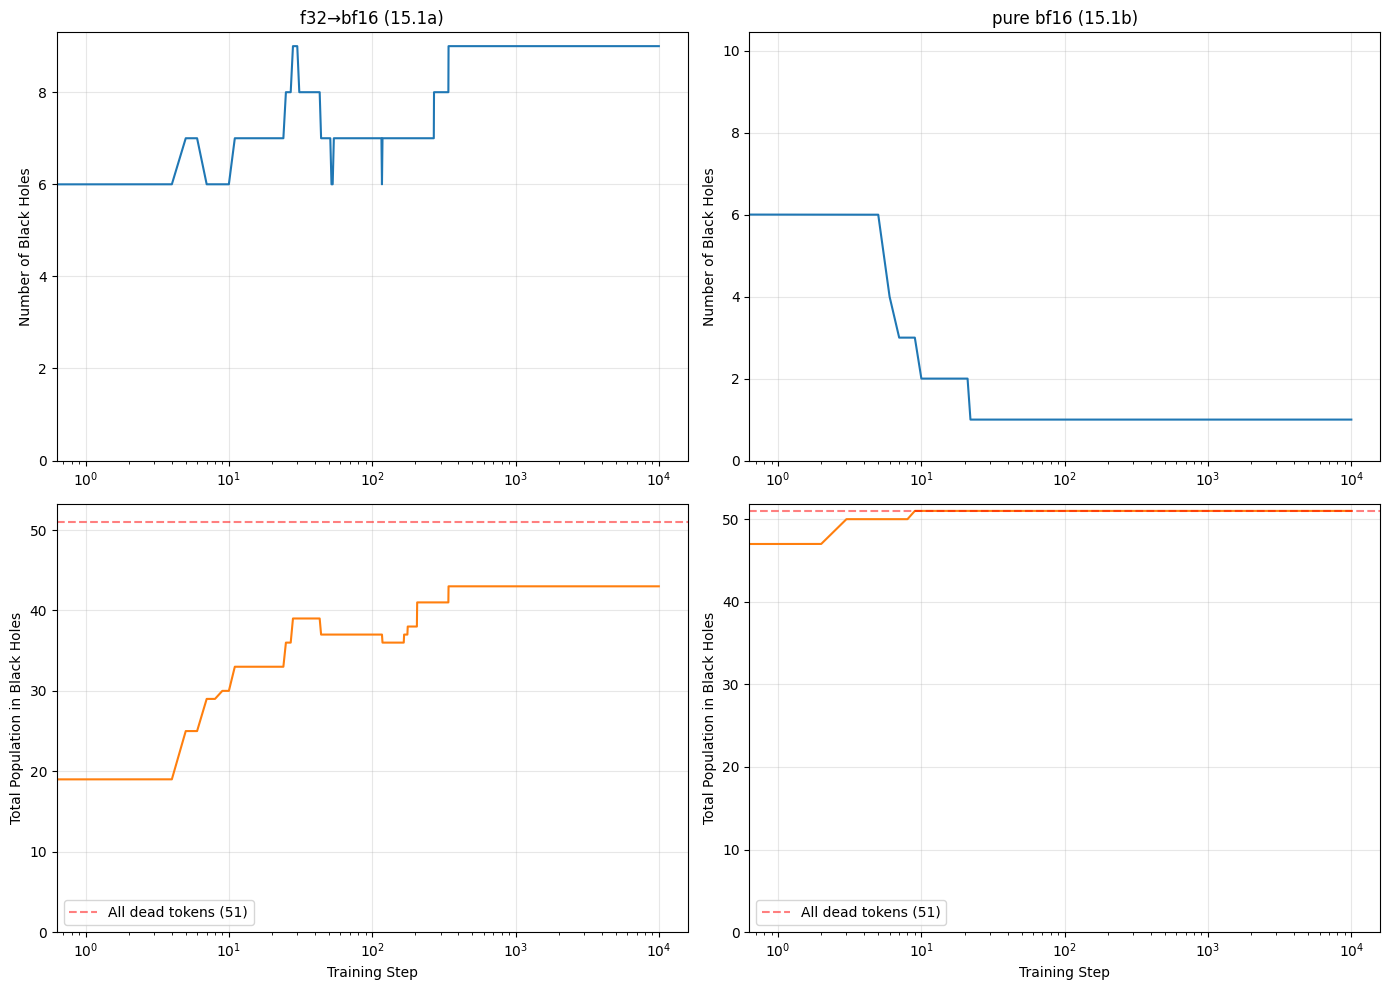


✓ Plot complete


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# f32→bf16 (left column)
ax1, ax3 = axes[:, 0]

ax1.plot(steps, bh_count_f32, color='C0', linewidth=1.5)
ax1.set_ylabel('Number of Black Holes')
ax1.set_title('f32→bf16 (15.1a)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)
ax1.set_xscale('log')

ax3.plot(steps, bh_pop_f32, color='C1', linewidth=1.5)
ax3.axhline(n_dead, color='red', linestyle='--', alpha=0.5, label=f'All dead tokens ({n_dead})')
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Total Population in Black Holes')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=0)
ax3.set_xscale('log')

# pure bf16 (right column)
ax2, ax4 = axes[:, 1]

ax2.plot(steps, bh_count_bf16, color='C0', linewidth=1.5)
ax2.set_ylabel('Number of Black Holes')
ax2.set_title('pure bf16 (15.1b)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)
ax2.set_xscale('log')

ax4.plot(steps, bh_pop_bf16, color='C1', linewidth=1.5)
ax4.axhline(n_dead, color='red', linestyle='--', alpha=0.5, label=f'All dead tokens ({n_dead})')
ax4.set_xlabel('Training Step')
ax4.set_ylabel('Total Population in Black Holes')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(bottom=0)
ax4.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n✓ Plot complete")

## Interpretation

In [9]:
print(f"\n{'='*80}")
print(f"INTERPRETATION")
print(f"{'='*80}\n")

# Analyze f32→bf16
print("f32→bf16 (15.1a):")
pop_change_f32 = bh_pop_f32[-1] - bh_pop_f32[0]
count_change_f32 = bh_count_f32[-1] - bh_count_f32[0]

if abs(pop_change_f32) < 5:  # Population roughly stable
    if count_change_f32 < -2:  # Count decreased
        verdict_f32 = "COALESCENCE"
        explanation_f32 = "Black holes merge (count drops) but population stays constant."
    elif count_change_f32 > 2:  # Count increased
        verdict_f32 = "FRAGMENTATION"
        explanation_f32 = "Black holes split (count rises) while population stays constant."
    else:
        verdict_f32 = "EQUILIBRIUM"
        explanation_f32 = "Both count and population stable - no net dynamics."
elif pop_change_f32 < -5:  # Population decreased
    if corr_f32 > 0.7:  # Strongly correlated
        verdict_f32 = "EVAPORATION"
        explanation_f32 = "Tokens escape from black holes (parallel decline in count and population)."
    else:
        verdict_f32 = "MIXED"
        explanation_f32 = "Both evaporation and coalescence occurring."
else:  # Population increased
    verdict_f32 = "CONDENSATION"
    explanation_f32 = "Singletons merging into black holes (population rises)."

print(f"  Verdict: {verdict_f32}")
print(f"  {explanation_f32}")
print(f"  r = {corr_f32:.3f}, Δcount = {count_change_f32:+d}, Δpop = {pop_change_f32:+d}")

# Analyze pure bf16
print(f"\npure bf16 (15.1b):")
pop_change_bf16 = bh_pop_bf16[-1] - bh_pop_bf16[0]
count_change_bf16 = bh_count_bf16[-1] - bh_count_bf16[0]

if abs(pop_change_bf16) < 5:
    if count_change_bf16 < -2:
        verdict_bf16 = "COALESCENCE"
        explanation_bf16 = "Black holes merge (count drops) but population stays constant."
    elif count_change_bf16 > 2:
        verdict_bf16 = "FRAGMENTATION"
        explanation_bf16 = "Black holes split (count rises) while population stays constant."
    else:
        verdict_bf16 = "EQUILIBRIUM"
        explanation_bf16 = "Both count and population stable - no net dynamics."
elif pop_change_bf16 < -5:
    if corr_bf16 > 0.7:
        verdict_bf16 = "EVAPORATION"
        explanation_bf16 = "Tokens escape from black holes (parallel decline in count and population)."
    else:
        verdict_bf16 = "MIXED"
        explanation_bf16 = "Both evaporation and coalescence occurring."
else:
    verdict_bf16 = "CONDENSATION"
    explanation_bf16 = "Singletons merging into black holes (population rises)."

print(f"  Verdict: {verdict_bf16}")
print(f"  {explanation_bf16}")
print(f"  r = {corr_bf16:.3f}, Δcount = {count_change_bf16:+d}, Δpop = {pop_change_bf16:+d}")

print(f"\n{'='*80}")


INTERPRETATION

f32→bf16 (15.1a):
  Verdict: CONDENSATION
  Singletons merging into black holes (population rises).
  r = 0.873, Δcount = +6, Δpop = +37

pure bf16 (15.1b):
  Verdict: CONDENSATION
  Singletons merging into black holes (population rises).
  r = -0.769, Δcount = -9, Δpop = +17



## Summary

This notebook distinguishes between two mechanisms for black hole count decline:

**Evaporation:**
- Tokens escape from black holes via gradient updates
- Both count and population decrease together (high correlation)

**Coalescence:**
- Tokens merge from smaller black holes into larger ones
- Count decreases but population stays constant (low correlation)

**Key metrics:**
1. Number of black holes over time
2. Total population in black holes over time
3. Correlation between the two

**Expected patterns:**
- **Evaporation:** r > 0.7, both curves decline
- **Coalescence:** r < 0.3, count drops but population flat
- **Mixed:** 0.3 < r < 0.7, both mechanisms active